<a href="https://colab.research.google.com/github/peppecappella/customer-churn-prediction-project/blob/main/1_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART I : Churn definition and Data preprocessing**

The approach described in the code is particularly necessary because the initial dataset provides only information about each customer's orders, without a predefined response variable for churn.

This situation is common in many customer relationship management (CRM) scenarios, where the dataset at hand primarily consists of transactional data (e.g., purchase dates, amounts spent) and lacks explicit labels or indicators for customer churn. Therefore, the initial phase involved defining the target variable.

Firstly, customers with less than 2 purchases were excluded from the analysis. Subsequently, the repurchase curve was calculated at the 87th percentile, obtaining a value slightly above 90 days.

The dataset was then divided into 90-day segments and the presence of purchases in the following 90 days was evaluated.

For each record in the dataset, the target churn variable was then assigned, which takes a value of 1 if the record does not reappear in the subsequent 90 days, 0 otherwise.

Customers who had not made any purchase in the 90 days prior to the reference date were also excluded from the analysis.

For each segment, the data were grouped by customer and the main features were calculated.

Finally, some additional features were calculated and the data are prepared for predictive modeling, including the removal of outliers and the creation of a labeled dataset that indicates whether a customer is considered churned or not.

## importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install lifetimes --upgrade

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import datetime as dt
import numpy as np
import math
import ast
from datetime import timedelta
import re
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, recall_score, precision_score
import xgboost as xgb
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from hyperopt.pyll.stochastic import sample

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

import sys
print("Versione Python:", sys.version)


Versione Python: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:39:40) [Clang 15.0.7 ]


In [ ]:
df=pd.read_csv('data/tbl_orders.csv')


In [ ]:
df.head(10)

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.00,2022-10-04T182851
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.00,2022-10-04T182851
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.00,2022-10-04T182851
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.00,2022-10-04T182851
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.00,2022-10-04T182851
5,c2ae3673970490406925dcd3f8a4d486,23,49,35002296,1,1.70,0.17,2022-10-31T130742
6,c2ae3673970490406925dcd3f8a4d486,23,49,32157580,1,1.90,0.19,2022-10-31T130742
7,c2ae3673970490406925dcd3f8a4d486,23,49,35930902,1,0.70,0.07,2022-10-31T130742
8,c2ae3673970490406925dcd3f8a4d486,23,49,81268736,1,9.90,0.99,2022-10-31T130742
9,c2ae3673970490406925dcd3f8a4d486,23,49,35930965,1,2.25,0.23,2022-10-31T130742


# compute the average lifetime of customers.

Converts the 'purchase_datetime' column to datetime format, groups the data by 'customer_id', calculates the first and last purchase dates for each customer, computes the time elapsed from the first to the last purchase in days, and finally creates a new DataFrame with the result.

In [ ]:

df_temp=df.copy()
df_temp['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

grouped = df_temp.groupby('customer_id').agg(first_purchase=pd.NamedAgg(column='purchase_datetime', aggfunc='min'),
                                        last_purchase=pd.NamedAgg(column='purchase_datetime', aggfunc='max'))

grouped['T'] = 1+(grouped['last_purchase'] - grouped['first_purchase']).dt.days

result_df = grouped[['T']].reset_index()

In [ ]:
result_df['T'].mean()

79.05584151189814

In [ ]:
average_T=result_df['T'].mean()

In [ ]:
average_T

79.05584151189814

## removes outliers from the 'gross_price' column of the DataFrame.

In [ ]:
z_scores = stats.zscore(df['gross_price'])

threshold = 9

outlier_indices = (z_scores > threshold) | (z_scores < -threshold)

df_no_outliers = df[~outlier_indices]
df=df_no_outliers.copy()


## Count the number of purchases on different dates.

In [ ]:
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

df['purchase_date'] = df['purchase_datetime'].dt.date

result = df.groupby('customer_id')['purchase_date'].nunique().reset_index()


In [ ]:
result['purchase_date'].min()

1

In [ ]:
result.shape

(104090, 2)

## I remove customers with fewer than 2 purchases on different days (the model must be applied to repeat customers)

In [ ]:
filtered_result = result[result['purchase_date'] >= 2]

In [ ]:
filtered_df = df[df['customer_id'].isin(filtered_result['customer_id'])]
df=filtered_df.copy()

In [ ]:
df.shape

(954527, 9)

## compute the repurchase curve

In [ ]:
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime']).dt.date

grouped = df.groupby('customer_id')['purchase_datetime'].agg(list).reset_index()

grouped.rename(columns={'purchase_datetime': 'purchase_date_list'}, inplace=True)

new_df = pd.DataFrame(grouped)
new_df

,customer_id,purchase_date_list
0,23,"[2022-10-04, 2022-10-04, 2022-10-04, 2022-10-0..."
1,30,"[2022-06-11, 2022-07-23, 2022-07-23]"
2,32,"[2023-03-18, 2023-03-18, 2023-03-18, 2023-03-1..."
3,48,"[2022-08-11, 2022-08-11, 2022-08-11, 2022-11-0..."
4,50,"[2023-01-18, 2023-01-18, 2023-02-19, 2023-02-19]"
...,...,...
70246,928707,"[2023-04-27, 2023-04-27, 2023-04-27, 2023-04-2..."
70247,928777,"[2023-04-27, 2023-04-27, 2023-04-27, 2023-04-2..."
70248,929438,"[2023-04-29, 2023-04-29, 2023-04-29, 2023-04-3..."
70249,929899,"[2023-04-27, 2023-04-30, 2023-04-30, 2023-04-3..."


In [ ]:
def clean_and_sort(dates_list):
    return sorted(list(set(dates_list)))

new_df['purchase_date_list'] = new_df['purchase_date_list'].apply(clean_and_sort)


def calculate_avg_date_distance(dates_list):
    if len(dates_list) <= 1:
        return None

    dates_list = sorted(dates_list)
    date_differences = [(dates_list[i+1] - dates_list[i]).days for i in range(len(dates_list) - 1)]
    return sum(date_differences) / len(date_differences)


In [ ]:
new_df['avg_date_distance'] = new_df['purchase_date_list'].apply(calculate_avg_date_distance)

In [ ]:
new_df

,customer_id,purchase_date_list,avg_date_distance
0,23,"[2022-10-04, 2022-10-31, 2022-11-17, 2022-11-2...",23.166667
1,30,"[2022-06-11, 2022-07-23]",42.000000
2,32,"[2023-03-18, 2023-04-02]",15.000000
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...",23.818182
4,50,"[2023-01-18, 2023-02-19]",32.000000
...,...,...,...
70246,928707,"[2023-04-27, 2023-04-30]",3.000000
70247,928777,"[2023-04-27, 2023-04-30]",3.000000
70248,929438,"[2023-04-29, 2023-04-30]",1.000000
70249,929899,"[2023-04-27, 2023-04-30]",3.000000


In [ ]:
new_df['avg_date_distance'].describe()

count    70251.000000
mean        46.623491
std         50.447029
min          1.000000
25%         14.166667
50%         30.000000
75%         59.333333
max        359.000000
Name: avg_date_distance, dtype: float64

In [ ]:
print("On average, engaged customers make a purchase every",
      new_df['avg_date_distance'].mean(),
      "days")


On average, engaged customers make a purchase every 46.62349064551822 days


In [ ]:
percentile_90 = np.percentile(new_df['avg_date_distance'].dropna(), 90)

print("Approximately 90% of customers repurchase every:", percentile_90, "days")


Approximately 90% of customers repurchase every: 107.66666666666667 days


## Show repurchase curve

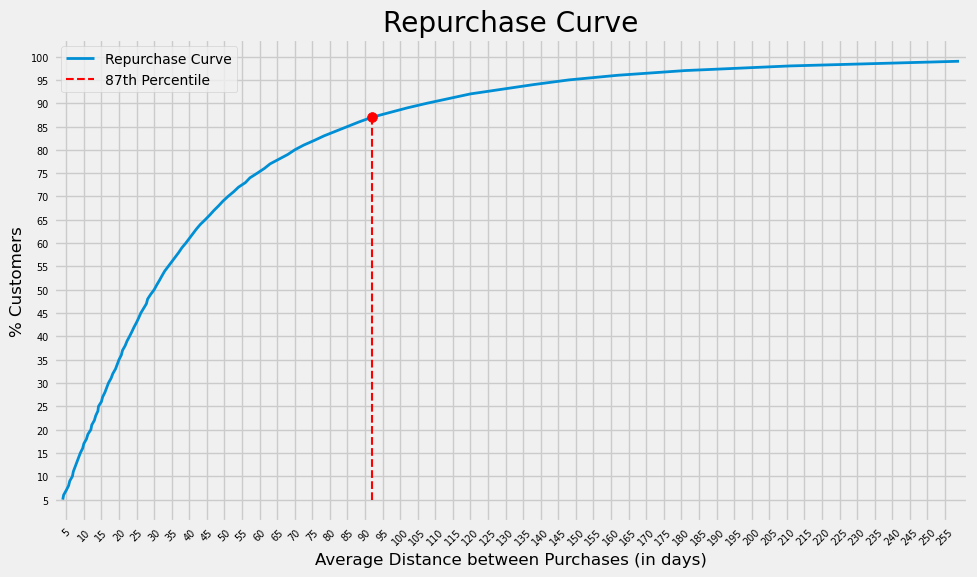

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

percentiles = range(5, 100)
percentile_values = [np.percentile(new_df['avg_date_distance'].dropna(), p) for p in percentiles]

df_percentiles = pd.DataFrame({'Percentile': percentiles, 'Value': percentile_values})

plt.figure(figsize=(10, 6))

plt.plot(df_percentiles['Value'], df_percentiles['Percentile'], linewidth=2.0, label='Repurchase Curve', zorder=1)

f = interp1d(df_percentiles['Percentile'], df_percentiles['Value'])
value_at_87th_percentile_on_curve = f(87)

plt.plot([value_at_87th_percentile_on_curve, value_at_87th_percentile_on_curve], [5, 87], color='red', linestyle='--', linewidth=1.5, label='87th Percentile', zorder=2)

plt.scatter(value_at_87th_percentile_on_curve, 87, color='red', edgecolor='red', s=50, zorder=3)

plt.xlabel('Average Distance between Purchases (in days)', size=12)
plt.ylabel('% Customers', size=12)
plt.title('Repurchase Curve')

plt.xticks(range(5, int(max(percentile_values)) + 1, 5), fontsize=7, rotation=45)
plt.yticks(range(5, 101, 5), fontsize=7)

plt.grid(True)
plt.legend(fontsize=10)

plt.margins(x=0.01)
plt.tight_layout()

plt.show()


In [ ]:
df_percentili.tail(20)

,Percentile,Valore
75,80,70.000000
76,81,72.500000
77,82,75.500000
78,83,78.333333
79,84,81.666667
80,85,85.000000
81,86,88.333333
82,87,92.000000
83,88,97.000000
84,89,102.000000


# Set the first reference date to 90 days from the date of the first purchase.
### if a customer has not made another purchase after this date, then they are considered a churner.

In [ ]:
percentile_90=math.floor(percentile_90)-2

In [ ]:
percentile_90

105

In [ ]:
min_date=df['purchase_date'].min()

reference_date = min_date + pd.Timedelta(days=percentile_90)

print("La reference_date è:", reference_date)

La reference_date è: 2022-08-14


In [ ]:
min_date

datetime.date(2022, 5, 1)

In [ ]:
def filter_dates_greater(date_list):
    return [date for date in date_list if date >= reference_date]

def filter_dates_less(date_list):
    return [date for date in date_list if date <= reference_date]

new_df['filtered_dates_greater'] = new_df['purchase_date_list'].apply(filter_dates_greater)
new_df['filtered_dates_less'] = new_df['purchase_date_list'].apply(filter_dates_less)

In [ ]:
new_df.head()

,customer_id,purchase_date_list,avg_date_distance,filtered_dates_greater,filtered_dates_less
0,23,"[2022-10-04, 2022-10-31, 2022-11-17, 2022-11-2...",23.166667,"[2022-10-04, 2022-10-31, 2022-11-17, 2022-11-2...",[]
1,30,"[2022-06-11, 2022-07-23]",42.000000,[],"[2022-06-11, 2022-07-23]"
2,32,"[2023-03-18, 2023-04-02]",15.000000,"[2023-03-18, 2023-04-02]",[]
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...",23.818182,"[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11]
4,50,"[2023-01-18, 2023-02-19]",32.000000,"[2023-01-18, 2023-02-19]",[]


In [ ]:
new_df.shape

(70251, 5)

## exclude from the analysis customers who have not made a purchase before the reference date.


In [ ]:
new_df = new_df[new_df['filtered_dates_less'].apply(len) > 0]

In [ ]:
new_df.shape

(30744, 5)

## Exclude from the analysis customers who have not made a purchase within 90 days of the reference date

In [ ]:
pre_reference_date = reference_date - timedelta(days=percentile_90)

pre_reference_date

datetime.date(2022, 5, 1)

In [ ]:
def filter_dates_pre_and_reference(date_list):
    return [date for date in date_list if pre_reference_date <= date <= reference_date]

new_df['filtered_dates_pre_and_reference'] = new_df['purchase_date_list'].apply(filter_dates_pre_and_reference)

new_df.head(10)

,customer_id,purchase_date_list,avg_date_distance,filtered_dates_greater,filtered_dates_less,filtered_dates_pre_and_reference
1,30,"[2022-06-11, 2022-07-23]",42.000000,[],"[2022-06-11, 2022-07-23]","[2022-06-11, 2022-07-23]"
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...",23.818182,"[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11],[2022-08-11]
5,76,"[2022-05-17, 2023-03-08]",295.000000,[2023-03-08],[2022-05-17],[2022-05-17]
7,109,"[2022-08-02, 2022-08-23]",21.000000,[2022-08-23],[2022-08-02],[2022-08-02]
8,146,"[2022-06-14, 2022-07-16]",32.000000,[],"[2022-06-14, 2022-07-16]","[2022-06-14, 2022-07-16]"
12,194,"[2022-05-21, 2022-07-29, 2023-04-23, 2023-04-25]",113.000000,"[2023-04-23, 2023-04-25]","[2022-05-21, 2022-07-29]","[2022-05-21, 2022-07-29]"
14,198,"[2022-05-12, 2022-07-08, 2022-10-25]",83.000000,[2022-10-25],"[2022-05-12, 2022-07-08]","[2022-05-12, 2022-07-08]"
19,231,"[2022-06-28, 2022-07-04, 2022-07-14, 2022-07-1...",32.888889,"[2022-08-24, 2022-11-04, 2023-01-03, 2023-01-0...","[2022-06-28, 2022-07-04, 2022-07-14, 2022-07-1...","[2022-06-28, 2022-07-04, 2022-07-14, 2022-07-1..."
20,234,"[2022-05-20, 2022-07-07, 2022-07-31]",36.000000,[],"[2022-05-20, 2022-07-07, 2022-07-31]","[2022-05-20, 2022-07-07, 2022-07-31]"
21,241,"[2022-07-11, 2022-09-25, 2023-03-04]",118.000000,"[2022-09-25, 2023-03-04]",[2022-07-11],[2022-07-11]


In [ ]:
new_df = new_df[new_df['filtered_dates_pre_and_reference'].apply(len) > 0]

new_df.head()

df=new_df.copy()

In [ ]:
new_df.shape

(30744, 6)

## Compute the churners from the first lookback


In [ ]:
def calculate_churn(filtered_dates_greater_list):
    return int(len(filtered_dates_greater_list) == 0)

df['churn'] = df['filtered_dates_greater'].apply(calculate_churn)
df.head()

,customer_id,purchase_date_list,avg_date_distance,filtered_dates_greater,filtered_dates_less,filtered_dates_pre_and_reference,churn
1,30,"[2022-06-11, 2022-07-23]",42.000000,[],"[2022-06-11, 2022-07-23]","[2022-06-11, 2022-07-23]",1
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...",23.818182,"[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11],[2022-08-11],0
5,76,"[2022-05-17, 2023-03-08]",295.000000,[2023-03-08],[2022-05-17],[2022-05-17],0
7,109,"[2022-08-02, 2022-08-23]",21.000000,[2022-08-23],[2022-08-02],[2022-08-02],0
8,146,"[2022-06-14, 2022-07-16]",32.000000,[],"[2022-06-14, 2022-07-16]","[2022-06-14, 2022-07-16]",1


In [ ]:
total_rows = len(df)
churn_rows = df['churn'].sum()
churn_rate = churn_rows / total_rows

churner_count = (df['churn'] == 1).sum()
non_churner_count = (df['churn'] == 0).sum()

print("Number of Churners:", churner_count)
print("Number of Non-Churners:", non_churner_count)

print("Churn Rate:", churn_rate)


Number of Churners: 6161
Number of Non-Churners: 24583
Churn Rate: 0.2003968253968254


**Approximately 17% of customers who made 2 purchases, with at least one made within 90 days of the reference date, did not make another purchase after the reference date**

## creation of the labeled set

In [ ]:
import pandas as pd
import os

min_date = min(min(dates) for dates in df['filtered_dates_pre_and_reference'])

print("Minimum Date:", min_date)

columns_to_drop = [
    "purchase_date_list",
    "filtered_dates_greater",
    "filtered_dates_less",
    "filtered_dates_pre_and_reference",
    "avg_date_distance"
]

df = df.drop(columns_to_drop, axis=1)

if not os.path.exists("temp_data/first_lookback"):
    os.makedirs("temp_data/first_lookback")

df.to_csv("temp_data/first_lookback/labelled.csv", index=False)

Minimum Date: 2022-05-01


In [ ]:
df

,customer_id,churn
1,30,1
3,48,0
5,76,0
7,109,0
8,146,1
...,...,...
44734,525861,0
44737,525907,0
44738,525910,0
44745,525987,0


## read the orders file and filter only the records prior to the reference date

In [ ]:
df=pd.read_csv('data/tbl_orders.csv')

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])


df['purchase_datetime'] = df['purchase_datetime'].dt.date


# Filtra il dataframe mantenendo solo i record PRECEDENTI o uguali alla reference_date

df = df[df['purchase_datetime'] <= reference_date]


df = df[df['purchase_datetime'] >= pre_reference_date]

min_purchase_date = df["purchase_datetime"].min()
max_purchase_date = df["purchase_datetime"].max()

print("Data minima:", min_purchase_date)
print("Data massima:", max_purchase_date)

Data minima: 2022-05-01
Data massima: 2022-08-14


## add customer information to the labeled set = create the file lookback_orders.csv

In [ ]:
df2=pd.read_csv('temp_data/first_lookback/labelled.csv')
result = df2.merge(df, on='customer_id', how='inner')
result.head()
result.to_csv('temp_data/first_lookback/lookback_orders.csv',index=False)

## First lookback features engineering
**Aggregate variables are calculated for each customer id and saved in separate csv files.**

In [ ]:
import os
import pandas as pd
from lifetimes.utils import summary_data_from_transaction_data


def verifica_e_crea_cartella(path):
    if not os.path.exists(path):
        os.makedirs(path)


def carica_df_da_csv(file_path):
    df = pd.read_csv(file_path)
    return df.replace(np.nan, 0)

# Funzione per salvare un DataFrame in un file CSV
def salva_df_in_csv(df, file_path):
    verifica_e_crea_cartella(os.path.dirname(file_path))
    df.to_csv(file_path, index=False)

def calcola_acquisti_resti(df):
    acquisti_df = df[df['direction'] == 1]
    result_acquisti = acquisti_df.groupby('customer_id').size().reset_index(name='numero_prodotti_acquistati_totale')
    resti_df = df[df['direction'] == -1]
    result_resti = resti_df.groupby('customer_id').size().reset_index(name='numero_prodotti_restituiti_totale')
    merged_df = pd.merge(result_acquisti, result_resti, on='customer_id', how='outer')
    merged_df.fillna(0, inplace=True)
    return merged_df

def calcola_ordini_per_categoria(file_path_orders, file_path_products):
    df = pd.read_csv(file_path_orders)
    df = df[df['direction'] == 1]  # Filtra per acquisti
    df2 = pd.read_csv(file_path_products)
    merged_df = pd.merge(df, df2, on='product_id', how='left')
    merged_df.fillna("prodotto non trovato", inplace=True)
    grouped = merged_df.groupby(['customer_id'])
    result = grouped.apply(lambda group: pd.Series({
        'Num_Rows': len(group),
        'Num_Unique_Product_Class': group['product_class'].nunique()
    })).reset_index()
    result['ordini_per_categoria'] = result['Num_Rows'] / result['Num_Unique_Product_Class']
    return result[['customer_id', 'ordini_per_categoria']]

def calcola_spesa_e_metriche_RFM(file_path, observation_period_end):
    df = pd.read_csv(file_path)
    df = df[(df['direction'] == 1) & (df['gross_price'] > 0)]
    df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])
    df_daily = df.groupby(['customer_id', df['purchase_datetime'].dt.date])['gross_price'].sum().reset_index()
    df_daily.rename(columns={'gross_price': 'daily_total_revenue'}, inplace=True)
    total_spent_per_customer = df_daily.groupby("customer_id")["daily_total_revenue"].sum().reset_index()
    total_spent_per_customer.columns = ["customer_id", "total_spent"]
    avg_spent_per_customer = df_daily.groupby("customer_id")["daily_total_revenue"].mean().reset_index()
    avg_spent_per_customer.columns = ["customer_id", "avg_daily_spent"]
    df_rfmt = summary_data_from_transaction_data(df_daily, 'customer_id', 'purchase_datetime', 'daily_total_revenue', observation_period_end=observation_period_end)
    df_rfmt.reset_index(inplace=True)
    df_rfmt.rename(columns={'index': 'customer_id'}, inplace=True)
    merged_df = pd.merge(total_spent_per_customer, avg_spent_per_customer, on='customer_id', how='inner')
    merged_df = pd.merge(merged_df, df_rfmt, on='customer_id', how='inner')
    return merged_df

def calcola_numero_categorie_prodotto(df, df2):
    merged_df = pd.merge(df, df2, on='product_id', how='left')
    merged_df.fillna("prodotto non trovato", inplace=True)
    acquisti_grouped = merged_df[merged_df['direction'] == 1].groupby('customer_id')['product_class'].unique()
    result_acquisti = acquisti_grouped.reset_index(name='product_classes_acquistate')
    result_acquisti['num_categories_acquistate'] = result_acquisti['product_classes_acquistate'].apply(lambda x: len(x))
    resti_grouped = merged_df[merged_df['direction'] == -1].groupby('customer_id')['product_class'].unique()
    result_resti = resti_grouped.reset_index(name='product_classes_restitute')
    result_resti['num_categories_restitute'] = result_resti['product_classes_restitute'].apply(lambda x: len(x))
    final_df = pd.merge(result_acquisti, result_resti, on='customer_id', how='outer')
    final_df.fillna({"product_classes_acquistate": "", "product_classes_restitute": "", "num_categories_acquistate": 0, "num_categories_restitute": 0}, inplace=True)
    return final_df

def calcola_return_rate(df):
    grouped = df.groupby(['customer_id', 'direction']).size().reset_index(name='count')
    pivot_df = grouped.pivot(index='customer_id', columns='direction', values='count').reset_index()
    pivot_df.columns.name = None
    pivot_df = pivot_df.rename(columns={1: 'prodotti_acquistati', -1: 'prodotti_restituiti'})
    pivot_df.fillna(0, inplace=True)
    pivot_df['return_rate'] = pivot_df.apply(lambda row:
        0 if row['prodotti_acquistati'] == 0 else (row['prodotti_restituiti'] / row['prodotti_acquistati']) * 100, axis=1)
    return pivot_df

def calcola_spesa_settimanale_media_variazione(df):
    df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])
    df['week'] = df['purchase_datetime'].dt.isocalendar().week
    df['year'] = df['purchase_datetime'].dt.isocalendar().year
    df_acquisti = df[(df['direction'] == 1) & (df['gross_price'] >= 0)]
    spesa_settimanale = df_acquisti.groupby(['customer_id', 'year', 'week'])['gross_price'].sum().reset_index()
    spesa_media = spesa_settimanale.groupby('customer_id')['gross_price'].mean().reset_index()
    spesa_media = spesa_media.rename(columns={'gross_price': 'spesa_settimanale_media'})
    spesa_settimanale = spesa_settimanale.sort_values(by=['customer_id', 'year', 'week'])
    spesa_settimanale['variazione_percentuale'] = spesa_settimanale.groupby('customer_id')['gross_price'].pct_change().round(2) * 100
    spesa_settimanale['variazione_percentuale'] = spesa_settimanale.groupby('customer_id')['variazione_percentuale'].transform(lambda x: x.fillna(0, limit=1))
    variazione_media_spesa = spesa_settimanale.groupby('customer_id')['variazione_percentuale'].mean().reset_index(name='variazione_media_spesa').round(2)
    return spesa_media, variazione_media_spesa

def calcola_frequenza_media_acquisti_sconto(df):
    df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])
    df['week'] = df['purchase_datetime'].dt.isocalendar().week
    df['year'] = df['purchase_datetime'].dt.isocalendar().year
    df_acquisti = df[df['direction'] == 1]
    frequenza_acquisti = df_acquisti.groupby(['customer_id', 'year', 'week']).size().reset_index(name='num_acquisti_settimanali')
    frequenza_media_acquisti = frequenza_acquisti.groupby('customer_id')['num_acquisti_settimanali'].mean().reset_index()
    frequenza_media_acquisti = frequenza_media_acquisti.rename(columns={'num_acquisti_settimanali': 'frequenza_media_acquisti_settimanali'}).round(2)
    df_acquisti_sconto = df[(df['direction'] == 1) & (df['price_reduction'] > 0)]
    frequenza_acquisti_sconto = df_acquisti_sconto.groupby(['customer_id', 'year', 'week']).size().reset_index(name='num_acquisti_sconto_settimanali')
    frequenza_media_acquisti_sconto = frequenza_acquisti_sconto.groupby('customer_id')['num_acquisti_sconto_settimanali'].mean().reset_index()
    frequenza_media_acquisti_sconto = frequenza_media_acquisti_sconto.rename(columns={'num_acquisti_sconto_settimanali': 'frequenza_media_acquisti_sconto_settimanali'}).round(2)
    return frequenza_media_acquisti, frequenza_media_acquisti_sconto

def calcola_num_visited_stores(df):
    customer_stores = df.groupby("customer_id")["store_id"].unique().reset_index()
    customer_stores["num_visited_stores"] = customer_stores["store_id"].apply(len)
    return customer_stores

In [ ]:
import pandas as pd

def estrai_churn(df_orders):
    churn_data = df_orders[['customer_id', 'churn']].drop_duplicates()
    return churn_data


def aggrega_features(file_path_orders, file_path_products, observation_period_end):
    # Carica i dati da CSV
    df_orders = carica_df_da_csv(file_path_orders)
    df_products = carica_df_da_csv(file_path_products)

    # Calcola le features
    acquisti_resti = calcola_acquisti_resti(df_orders)
    ordini_per_categoria = calcola_ordini_per_categoria(file_path_orders, file_path_products)
    spesa_e_metriche_RFM = calcola_spesa_e_metriche_RFM(file_path_orders, observation_period_end)
    numero_categorie_prodotto = calcola_numero_categorie_prodotto(df_orders, df_products)
    return_rate = calcola_return_rate(df_orders)
    spesa_media, variazione_media_spesa = calcola_spesa_settimanale_media_variazione(df_orders)
    frequenza_media_acquisti, frequenza_media_acquisti_sconto = calcola_frequenza_media_acquisti_sconto(df_orders)
    num_visited_stores = calcola_num_visited_stores(df_orders)
    #cltv=calculate_cltv(df_orders)

    # Unisci tutte le features utilizzando outer join e sostituisci i valori NaN con 0
    features_df = acquisti_resti.merge(ordini_per_categoria, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(spesa_e_metriche_RFM, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(numero_categorie_prodotto, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(return_rate, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(spesa_media, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(variazione_media_spesa, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(frequenza_media_acquisti, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(frequenza_media_acquisti_sconto, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0
    features_df = features_df.merge(num_visited_stores, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)  # Sostituisci NaN con 0


    churn_data = estrai_churn(df_orders)
    features_df = features_df.merge(churn_data, on='customer_id', how='outer')
    features_df.fillna(0, inplace=True)


    return features_df


file_path_orders = 'temp_data/first_lookback/lookback_orders.csv'
file_path_products = 'data/tbl_products.csv'
observation_period_end = '2022-07-30'
features_df_t1 = aggrega_features(file_path_orders, file_path_products, observation_period_end)
features_df_t1['reference_date']=reference_date

features_df_t1['CLTV'] = ((features_df_t1['avg_daily_spent']) * (features_df_t1['frequency'] + 1)) * average_T

features_df_t1.to_csv('temp_data/first_lookback/first_lookback_with_features.csv',index=False)

In [ ]:
features_df_t1.columns

Index(['customer_id', 'numero_prodotti_acquistati_totale',
       'numero_prodotti_restituiti_totale', 'ordini_per_categoria',
       'total_spent', 'avg_daily_spent', 'frequency', 'recency', 'T',
       'monetary_value', 'product_classes_acquistate',
       'num_categories_acquistate', 'product_classes_restitute',
       'num_categories_restitute', 'prodotti_restituiti',
       'prodotti_acquistati', 'return_rate', 'spesa_settimanale_media',
       'variazione_media_spesa', 'frequenza_media_acquisti_settimanali',
       'frequenza_media_acquisti_sconto_settimanali', 'store_id',
       'num_visited_stores', 'churn', 'reference_date', 'CLTV'],
      dtype='object')

In [ ]:
features_df_t1.head()

,customer_id,numero_prodotti_acquistati_totale,numero_prodotti_restituiti_totale,ordini_per_categoria,total_spent,avg_daily_spent,frequency,recency,T,monetary_value,...,return_rate,spesa_settimanale_media,variazione_media_spesa,frequenza_media_acquisti_settimanali,frequenza_media_acquisti_sconto_settimanali,store_id,num_visited_stores,churn,reference_date,CLTV
0,30,12,0.0,4.0,10179.56,5089.78,1.0,42.0,49.0,10176.46,...,0.0,5089.78,164086.5,6.0,6.0,[49],1,1,2022-08-14,804753.682021
1,48,3,0.0,3.0,0.00,0.00,0.0,0.0,0.0,0.00,...,0.0,232.50,0.0,3.0,2.0,[49],1,0,2022-08-14,0.000000
2,76,1,0.0,1.0,9.85,9.85,0.0,0.0,74.0,0.00,...,0.0,9.85,0.0,1.0,0.0,[9],1,0,2022-08-14,778.700039
3,109,1,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.00,...,0.0,2.60,0.0,1.0,0.0,[9],1,0,2022-08-14,0.000000
4,146,5,0.0,2.5,329.60,164.80,1.0,32.0,46.0,150.00,...,0.0,164.80,-8.0,2.5,2.5,[9],1,1,2022-08-14,26056.805362


# Define the second lookback
**I use a second reference date 90 days from the first reference date**

In [ ]:
import pandas as pd

df = pd.read_csv('data/tbl_orders.csv')

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

df['purchase_date'] = df['purchase_datetime'].dt.date

min_date = df['purchase_date'].min()

reference_date = min_date + pd.Timedelta(days=105)

print("The second reference_date is:", reference_date)


The second reference_date is: 2022-08-14


In [ ]:
reference_date

datetime.date(2022, 8, 14)

In [ ]:
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime']).dt.date

grouped = df.groupby('customer_id')['purchase_datetime'].agg(list).reset_index()

grouped.rename(columns={'purchase_datetime': 'purchase_date_list'}, inplace=True)

new_df = pd.DataFrame(grouped)

def clean_and_sort(dates_list):
    return sorted(list(set(dates_list)))

new_df['purchase_date_list'] = new_df['purchase_date_list'].apply(clean_and_sort)

In [ ]:
def filter_dates_greater(date_list):
    return [date for date in date_list if date >= reference_date]

def filter_dates_less(date_list):
    return [date for date in date_list if date <= reference_date]

new_df['filtered_dates_greater'] = new_df['purchase_date_list'].apply(filter_dates_greater)
new_df['filtered_dates_less'] = new_df['purchase_date_list'].apply(filter_dates_less)

In [ ]:
new_df

,customer_id,purchase_date_list,filtered_dates_greater,filtered_dates_less
0,23,"[2022-10-04, 2022-10-31, 2022-11-17, 2022-11-2...","[2022-10-04, 2022-10-31, 2022-11-17, 2022-11-2...",[]
1,30,"[2022-06-11, 2022-07-23]",[],"[2022-06-11, 2022-07-23]"
2,32,"[2023-03-18, 2023-04-02]","[2023-03-18, 2023-04-02]",[]
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...","[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11]
4,50,"[2023-01-18, 2023-02-19]","[2023-01-18, 2023-02-19]",[]
...,...,...,...,...
104129,934484,[2023-04-30],[2023-04-30],[]
104130,934581,[2023-04-30],[2023-04-30],[]
104131,934620,[2023-04-30],[2023-04-30],[]
104132,934660,[2023-04-30],[2023-04-30],[]


In [ ]:
new_df = new_df[new_df['filtered_dates_less'].apply(len) > 0]

pre_reference_date = reference_date - timedelta(days=percentile_90)

def filter_dates_pre_and_reference(date_list):
    return [date for date in date_list if pre_reference_date <= date <= reference_date]

new_df['filtered_dates_pre_and_reference'] = new_df['purchase_date_list'].apply(filter_dates_pre_and_reference)

new_df = new_df[new_df['filtered_dates_pre_and_reference'].apply(len) > 0]

df = new_df.copy()

In [ ]:
df

,customer_id,purchase_date_list,filtered_dates_greater,filtered_dates_less,filtered_dates_pre_and_reference
1,30,"[2022-06-11, 2022-07-23]",[],"[2022-06-11, 2022-07-23]","[2022-06-11, 2022-07-23]"
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...","[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11],[2022-08-11]
6,76,"[2022-05-17, 2023-03-08]",[2023-03-08],[2022-05-17],[2022-05-17]
7,86,[2022-05-04],[],[2022-05-04],[2022-05-04]
10,109,"[2022-08-02, 2022-08-23]",[2022-08-23],[2022-08-02],[2022-08-02]
...,...,...,...,...,...
63262,525861,"[2022-08-14, 2022-12-02]","[2022-08-14, 2022-12-02]",[2022-08-14],[2022-08-14]
63270,525907,"[2022-08-14, 2022-09-20, 2022-09-25, 2022-10-0...","[2022-08-14, 2022-09-20, 2022-09-25, 2022-10-0...",[2022-08-14],[2022-08-14]
63271,525910,"[2022-08-14, 2023-01-02]","[2022-08-14, 2023-01-02]",[2022-08-14],[2022-08-14]
63281,525987,"[2022-08-14, 2022-09-11, 2022-09-16]","[2022-08-14, 2022-09-11, 2022-09-16]",[2022-08-14],[2022-08-14]


**CHURN RATE OF THE SECOND LOOKBACK**

In [ ]:
def calculate_churn(filtered_dates_greater_list):
    return int(len(filtered_dates_greater_list) == 0)

df['churn'] = df['filtered_dates_greater'].apply(calculate_churn)

total_rows = len(df)
churn_rows = df['churn'].sum()
churn_rate = churn_rows / total_rows

churner_count = (df['churn'] == 1).sum()
non_churner_count = (df['churn'] == 0).sum()

print("Number of Churners:", churner_count)
print("Number of Non-Churners:", non_churner_count)

print("Churn Rate:", churn_rate)

Number of Churners: 15010
Number of Non-Churners: 24692
Churn Rate: 0.3780665961412523


In [ ]:
df

,customer_id,purchase_date_list,filtered_dates_greater,filtered_dates_less,filtered_dates_pre_and_reference,churn
1,30,"[2022-06-11, 2022-07-23]",[],"[2022-06-11, 2022-07-23]","[2022-06-11, 2022-07-23]",1
3,48,"[2022-08-11, 2022-11-06, 2022-11-14, 2022-11-1...","[2022-11-06, 2022-11-14, 2022-11-15, 2022-12-2...",[2022-08-11],[2022-08-11],0
6,76,"[2022-05-17, 2023-03-08]",[2023-03-08],[2022-05-17],[2022-05-17],0
7,86,[2022-05-04],[],[2022-05-04],[2022-05-04],1
10,109,"[2022-08-02, 2022-08-23]",[2022-08-23],[2022-08-02],[2022-08-02],0
...,...,...,...,...,...,...
63262,525861,"[2022-08-14, 2022-12-02]","[2022-08-14, 2022-12-02]",[2022-08-14],[2022-08-14],0
63270,525907,"[2022-08-14, 2022-09-20, 2022-09-25, 2022-10-0...","[2022-08-14, 2022-09-20, 2022-09-25, 2022-10-0...",[2022-08-14],[2022-08-14],0
63271,525910,"[2022-08-14, 2023-01-02]","[2022-08-14, 2023-01-02]",[2022-08-14],[2022-08-14],0
63281,525987,"[2022-08-14, 2022-09-11, 2022-09-16]","[2022-08-14, 2022-09-11, 2022-09-16]",[2022-08-14],[2022-08-14],0


In [ ]:
import pandas as pd
import os

min_date = min(min(dates) for dates in df['filtered_dates_pre_and_reference'])

print("Minimum Date:", min_date)

columns_to_drop = [
    "purchase_date_list",
    "filtered_dates_greater",
    "filtered_dates_less",
    "filtered_dates_pre_and_reference"
]

df = df.drop(columns_to_drop, axis=1)

if not os.path.exists("temp_data/second_lookback"):
    os.makedirs("temp_data/second_lookback")

df.to_csv("temp_data/second_lookback/labelled.csv", index=False)

Minimum Date: 2022-05-01


In [ ]:
df

,customer_id,churn
1,30,1
3,48,0
6,76,0
7,86,1
10,109,0
...,...,...
63262,525861,0
63270,525907,0
63271,525910,0
63281,525987,0


## I repeat the operations performed for the first lookback

In [ ]:
df=pd.read_csv('data/tbl_orders.csv')

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])


df['purchase_datetime'] = df['purchase_datetime'].dt.date


# Filtra il dataframe mantenendo solo i record PRECEDENTI o uguali alla reference_date

df = df[df['purchase_datetime'] < reference_date]

#pre_reference_date = pd.to_datetime("2022-09-28")

df = df[df['purchase_datetime'] >= pre_reference_date]

min_purchase_date = df["purchase_datetime"].min()
max_purchase_date = df["purchase_datetime"].max()

print("Data minima:", min_purchase_date)
print("Data massima:", max_purchase_date)

Data minima: 2022-05-01
Data massima: 2022-08-13


In [ ]:
df.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime'],
      dtype='object')

In [ ]:
df2=pd.read_csv('temp_data/second_lookback/labelled.csv')
result = df2.merge(df, on='customer_id', how='inner')
result.head()
result.to_csv('temp_data/second_lookback/lookback_orders.csv',index=False)

In [ ]:
file_path_orders = 'temp_data/second_lookback/lookback_orders.csv'
file_path_products = 'data/tbl_products.csv'
observation_period_end = '2022-10-27'
features_df_t2 = aggrega_features(file_path_orders, file_path_products, observation_period_end)
features_df_t2['reference_date']=reference_date
features_df_t2['CLTV'] = ((features_df_t2['avg_daily_spent']) * (features_df_t2['frequency'] + 1)) * average_T
features_df_t2.to_csv('temp_data/second_lookback/second_lookback_with_features.csv',index=False)

In [ ]:
features_df_t2.columns

Index(['customer_id', 'numero_prodotti_acquistati_totale',
       'numero_prodotti_restituiti_totale', 'ordini_per_categoria',
       'total_spent', 'avg_daily_spent', 'frequency', 'recency', 'T',
       'monetary_value', 'product_classes_acquistate',
       'num_categories_acquistate', 'product_classes_restitute',
       'num_categories_restitute', 'prodotti_restituiti',
       'prodotti_acquistati', 'return_rate', 'spesa_settimanale_media',
       'variazione_media_spesa', 'frequenza_media_acquisti_settimanali',
       'frequenza_media_acquisti_sconto_settimanali', 'store_id',
       'num_visited_stores', 'churn', 'reference_date', 'CLTV'],
      dtype='object')

# Define the third lookback
**I use a third reference date 90 days from the second reference date**

In [ ]:
import pandas as pd

df = pd.read_csv('data/tbl_orders.csv')

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

df['purchase_date'] = df['purchase_datetime'].dt.date

min_date = df['purchase_date'].min()

reference_date = min_date + pd.Timedelta(days=3 * percentile_90)

print("The THIRD reference_date is:", reference_date)


The THIRD reference_date is: 2023-03-12


In [ ]:
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime']).dt.date

grouped = df.groupby('customer_id')['purchase_datetime'].agg(list).reset_index()

grouped.rename(columns={'purchase_datetime': 'purchase_date_list'}, inplace=True)

new_df = pd.DataFrame(grouped)

def clean_and_sort(dates_list):
    return sorted(list(set(dates_list)))

new_df['purchase_date_list'] = new_df['purchase_date_list'].apply(clean_and_sort)

def filter_dates_greater(date_list):
    return [date for date in date_list if date > reference_date]

def filter_dates_less(date_list):
    return [date for date in date_list if date <= reference_date]

new_df['filtered_dates_greater'] = new_df['purchase_date_list'].apply(filter_dates_greater)
new_df['filtered_dates_less'] = new_df['purchase_date_list'].apply(filter_dates_less)

new_df = new_df[new_df['filtered_dates_less'].apply(len) > 0]

pre_reference_date = reference_date - timedelta(days=percentile_90)

def filter_dates_pre_and_reference(date_list):
    return [date for date in date_list if pre_reference_date < date < reference_date]

new_df['filtered_dates_pre_and_reference'] = new_df['purchase_date_list'].apply(filter_dates_pre_and_reference)

new_df = new_df[new_df['filtered_dates_pre_and_reference'].apply(len) > 0]

df = new_df.copy()

**CHURN RATE OF THE THIRD LOOKBACK**

In [ ]:
def calculate_churn(filtered_dates_greater_list):
    return int(len(filtered_dates_greater_list) == 0)

df['churn'] = df['filtered_dates_greater'].apply(calculate_churn)

total_rows = len(df)
churn_rows = df['churn'].sum()
churn_rate = churn_rows / total_rows

churner_count = (df['churn'] == 1).sum()
non_churner_count = (df['churn'] == 0).sum()

print("Numero di Churner:", churner_count)
print("Numero di Non Churner:", non_churner_count)

print("Churn Rate:", churn_rate)

Numero di Churner: 35194
Numero di Non Churner: 15356
Churn Rate: 0.6962215628090999


In [ ]:
import pandas as pd
import os

min_date = min(min(dates) for dates in df['filtered_dates_pre_and_reference'])

print("Minimum Date:", min_date)

columns_to_drop = [
    "purchase_date_list",
    "filtered_dates_greater",
    "filtered_dates_less",
    "filtered_dates_pre_and_reference"
]

df = df.drop(columns_to_drop, axis=1)

if not os.path.exists("temp_data/third_lookback"):
    os.makedirs("temp_data/third_lookback")

df.to_csv("temp_data/third_lookback/labelled.csv", index=False)


Minimum Date: 2022-11-28


## I repeat the operations performed for the first and second lookbacks

In [ ]:
reference_date

datetime.date(2023, 3, 12)

In [ ]:
df=pd.read_csv('data/tbl_orders.csv')

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])


df['purchase_datetime'] = df['purchase_datetime'].dt.date


# Filtra il dataframe mantenendo solo i record PRECEDENTI o uguali alla reference_date

df = df[df['purchase_datetime'] < reference_date]

#pre_reference_date = pd.to_datetime("2022-09-28")

df = df[df['purchase_datetime'] >= pre_reference_date]

min_purchase_date = df["purchase_datetime"].min()
max_purchase_date = df["purchase_datetime"].max()

print("Data minima:", min_purchase_date)
print("Data massima:", max_purchase_date)


df2=pd.read_csv('temp_data/third_lookback/labelled.csv')
result = df2.merge(df, on='customer_id', how='inner')
result.head()
result.to_csv('temp_data/third_lookback/lookback_orders.csv',index=False)


file_path_orders = 'temp_data/third_lookback/lookback_orders.csv'
file_path_products = 'data/tbl_products.csv'
observation_period_end = '2023-01-25'
features_df_t3 = aggrega_features(file_path_orders, file_path_products, observation_period_end)
features_df_t3['reference_date']=reference_date
features_df_t3['CLTV'] = ((features_df_t3['avg_daily_spent']) * (features_df_t3['frequency'] + 1)) * average_T
features_df_t3.to_csv('temp_data/third_lookback/third_lookback_with_features.csv',index=False)


Data minima: 2022-11-27
Data massima: 2023-03-11


In [ ]:
features_df_t3.columns

Index(['customer_id', 'numero_prodotti_acquistati_totale',
       'numero_prodotti_restituiti_totale', 'ordini_per_categoria',
       'total_spent', 'avg_daily_spent', 'frequency', 'recency', 'T',
       'monetary_value', 'product_classes_acquistate',
       'num_categories_acquistate', 'product_classes_restitute',
       'num_categories_restitute', 'prodotti_restituiti',
       'prodotti_acquistati', 'return_rate', 'spesa_settimanale_media',
       'variazione_media_spesa', 'frequenza_media_acquisti_settimanali',
       'frequenza_media_acquisti_sconto_settimanali', 'store_id',
       'num_visited_stores', 'churn', 'reference_date', 'CLTV'],
      dtype='object')

# Merging the 3 lookbacks

In [ ]:
df1=pd.read_csv('temp_data/first_lookback/first_lookback_with_features.csv')

df2=pd.read_csv('temp_data/second_lookback/second_lookback_with_features.csv')

df3=pd.read_csv('temp_data/third_lookback/third_lookback_with_features.csv')

df1.shape

df2.shape

concatenated_df = pd.concat([df1, df2, df3], ignore_index=True)

concatenated_df.shape

df=concatenated_df.copy()

In [ ]:
# Specifica il nome delle colonne da eliminare in una lista
colonne_da_elimare = ['product_classes_acquistate',
                      'product_classes_restitute', 'product_classes_acquistate',
                      'product_classes_restitute']

# Usa il metodo drop per eliminarle dal DataFrame
df = df.drop(colonne_da_elimare, axis=1)

In [ ]:
df.columns

Index(['customer_id', 'numero_prodotti_acquistati_totale',
       'numero_prodotti_restituiti_totale', 'ordini_per_categoria',
       'total_spent', 'avg_daily_spent', 'frequency', 'recency', 'T',
       'monetary_value', 'num_categories_acquistate',
       'num_categories_restitute', 'prodotti_restituiti',
       'prodotti_acquistati', 'return_rate', 'spesa_settimanale_media',
       'variazione_media_spesa', 'frequenza_media_acquisti_settimanali',
       'frequenza_media_acquisti_sconto_settimanali', 'store_id',
       'num_visited_stores', 'churn', 'reference_date', 'CLTV'],
      dtype='object')

In [ ]:
df_sorted = df[['customer_id', 'numero_prodotti_acquistati_totale',
       'numero_prodotti_restituiti_totale', 'ordini_per_categoria',
       'total_spent','store_id', 'avg_daily_spent', 'frequency', 'recency', 'T',
       'monetary_value','CLTV','num_categories_acquistate',
       'num_categories_restitute', 'prodotti_restituiti',
       'prodotti_acquistati', 'return_rate', 'spesa_settimanale_media',
       'variazione_media_spesa', 'frequenza_media_acquisti_settimanali',
       'frequenza_media_acquisti_sconto_settimanali', 'num_visited_stores',
       'churn', 'reference_date']].sort_values(by='customer_id')


In [ ]:
df_sorted.reset_index(drop=True, inplace=True)
df=df_sorted

In [ ]:
df

,customer_id,numero_prodotti_acquistati_totale,numero_prodotti_restituiti_totale,ordini_per_categoria,total_spent,store_id,avg_daily_spent,frequency,recency,T,...,prodotti_restituiti,prodotti_acquistati,return_rate,spesa_settimanale_media,variazione_media_spesa,frequenza_media_acquisti_settimanali,frequenza_media_acquisti_sconto_settimanali,num_visited_stores,churn,reference_date
0,23,22.0,0.0,2.750000,169.40,[49],42.350,2.0,22.0,57.0,...,0.0,22.0,0.000000,42.350000,70.5,5.50,2.0,1,1,2023-03-12
1,30,12.0,0.0,4.000000,10179.56,[49],5089.780,1.0,42.0,49.0,...,0.0,12.0,0.000000,5089.780000,164086.5,6.00,6.0,1,1,2022-08-14
2,30,12.0,0.0,4.000000,10179.56,[49],5089.780,1.0,42.0,138.0,...,0.0,12.0,0.000000,5089.780000,164086.5,6.00,6.0,1,1,2022-08-14
3,48,3.0,0.0,3.000000,232.50,[49],232.500,0.0,0.0,77.0,...,0.0,3.0,0.000000,232.500000,0.0,3.00,2.0,1,0,2022-08-14
4,48,28.0,15.0,5.600000,670.58,[49],167.645,2.0,27.0,28.0,...,15.0,28.0,53.571429,223.526667,-53.0,9.33,5.5,1,0,2023-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120636,860082,1.0,0.0,1.000000,0.00,[34],0.000,0.0,0.0,0.0,...,0.0,1.0,0.000000,49.990000,0.0,1.00,0.0,1,0,2023-03-12
120637,860151,2.0,0.0,1.000000,0.00,[30],0.000,0.0,0.0,0.0,...,0.0,2.0,0.000000,70.400000,0.0,2.00,0.0,1,1,2023-03-12
120638,860220,1.0,0.0,1.000000,0.00,[5],0.000,0.0,0.0,0.0,...,0.0,1.0,0.000000,5.350000,0.0,1.00,0.0,1,0,2023-03-12
120639,860226,4.0,0.0,1.333333,0.00,[17],0.000,0.0,0.0,0.0,...,0.0,4.0,0.000000,47.080000,0.0,4.00,0.0,1,0,2023-03-12


## Compute additional features

In [ ]:
df['store_id'] = df['store_id'].str.replace(r'\[\s*', '[').str.replace(r'\s*\]', ']').str.replace(r'\s+', ',')
df['store_id'] = df['store_id'].str.strip('[]')
df['store_id'] = df['store_id'].str.replace(' ', ',')
df['last_store_visited'] = df['store_id'].str.split(',').str[-1]

cross_tab = pd.crosstab(df['last_store_visited'], df['churn'])
cross_tab['churn_rate'] = cross_tab[1] / (cross_tab[0] + cross_tab[1])
cross_tab = cross_tab.sort_values(by='churn_rate', ascending=False)

quantiles = []
for q in range(0, 101, 5):
    quantile_value = cross_tab['churn_rate'].quantile(q / 100)
    quantiles.append((q, quantile_value))

for q, value in quantiles:
    print(f"Quantile {q}%: {value}")

high_churn_rate_stores = cross_tab[cross_tab['churn_rate'] > 0.46].index.tolist()
low_churn_rate_stores = cross_tab[cross_tab['churn_rate'] < 0.46].index.tolist()
df['visited_churn_store'] = df['last_store_visited'].apply(lambda x: 1 if x in high_churn_rate_stores else 0)

Quantile 0%: 0.41039755351681956
Quantile 5%: 0.41667123346448326
Quantile 10%: 0.4262156224424475
Quantile 15%: 0.4300364985652664
Quantile 20%: 0.4414744565727046
Quantile 25%: 0.4462126232741617
Quantile 30%: 0.45363343951033663
Quantile 35%: 0.4553264693247029
Quantile 40%: 0.45705046600186355
Quantile 45%: 0.45901783293162784
Quantile 50%: 0.47308474062128614
Quantile 55%: 0.4757599753187988
Quantile 60%: 0.47642944118713004
Quantile 65%: 0.4778395681454797
Quantile 70%: 0.480979078142236
Quantile 75%: 0.48552833921088195
Quantile 80%: 0.49036245056810907
Quantile 85%: 0.4952774021646726
Quantile 90%: 0.5077969733494041
Quantile 95%: 0.5165243325899117
Quantile 100%: 0.5347454477889261


In [ ]:
df2 = pd.read_csv('data/tbl_customer_accounts.csv')
df2 = df2.drop_duplicates(subset=['customer_id'])
merged_df = pd.merge(df, df2, on='customer_id', how='left')
df = merged_df.copy()

def calculate_changed_store(row):
    if row['favorite_store'] == row['last_store_visited']:
        return 0
    else:
        return 1

df['changed_store'] = df.apply(calculate_changed_store, axis=1)

loyalty_mapping = {'business standard': 1, 'business premium': 2, 'standard': 3, 'premium': 4}
df['loyalty_score'] = df['loyalty_type'].map(loyalty_mapping)

df1 = df.copy()

df2 = pd.read_csv('data/tbl_customers.csv')
merged_df = pd.merge(df1, df2, on='customer_id', how='left')
df = merged_df.copy()


In [ ]:
reference_date = pd.Timestamp('2023-01-13')

df['birthdate'] = pd.to_datetime(df['birthdate'])

df['age'] = (reference_date - df['birthdate']).dt.days // 365


In [ ]:
from sklearn.preprocessing import LabelEncoder

gender_mapping = {'M': 1, 'F': 2}
df['sex'] = df['gender'].map(gender_mapping)
df.drop('gender', axis=1, inplace=True)

label_encoder = LabelEncoder()
df['privacy_score'] = label_encoder.fit_transform(df['flag_privacy'])

df['flag_phone_provided'].fillna(0, inplace=True)

label_encoder = LabelEncoder()
df['phone_provided_score'] = label_encoder.fit_transform(df['flag_phone_provided'])


In [ ]:
label_encoder = LabelEncoder()

df['privacy_score'] = label_encoder.fit_transform(df['flag_privacy'])

df['flag_phone_provided'].fillna(0, inplace=True)

label_encoder = LabelEncoder()

df['phone_provided_score'] = label_encoder.fit_transform(df['flag_phone_provided'])


In [ ]:
df_contacts=df[['address_id','email_provider','phone_provided_score']]

In [ ]:
df_contacts.head(10)

,address_id,email_provider,phone_provided_score
0,21,gmail.com,1
1,29,gmail.com,0
2,29,gmail.com,0
3,46,alice.it,1
4,46,alice.it,1
5,46,alice.it,1
6,48,gmail.com,1
7,557043,gmail.com,1
8,73,libero.it,1
9,73,libero.it,1


In [ ]:
import pandas as pd

df['reachable_by_mail'] = df['address_id'].notnull()

df['reachable_by_email'] = df['email_provider'].notnull()

df['reachable_by_phone'] = df['phone_provided_score'] > 0

reachability_summary = df[['reachable_by_mail', 'reachable_by_email', 'reachable_by_phone']].mean()

print(reachability_summary)

reachable_by_mail     1.000000
reachable_by_email    0.987475
reachable_by_phone    0.929203
dtype: float64


In [ ]:
columns_to_drop = ['address_id', 'birthdate', 'job_type', 'email_provider', 'flag_phone_provided', 'flag_privacy', 'activation_date', 'loyalty_type', 'account_id']

df.drop(columns=columns_to_drop, inplace=True)

df.to_csv('temp_data/labelled_set_with_features.csv',index=False)

In [ ]:
df

,customer_id,numero_prodotti_acquistati_totale,numero_prodotti_restituiti_totale,ordini_per_categoria,total_spent,store_id,avg_daily_spent,frequency,recency,T,...,loyatlty_status,changed_store,loyalty_score,age,sex,privacy_score,phone_provided_score,reachable_by_mail,reachable_by_email,reachable_by_phone
0,23,22.0,0.0,2.750000,169.40,49,42.350,2.0,22.0,57.0,...,1,1,3,44,2,1,1,True,True,True
1,30,12.0,0.0,4.000000,10179.56,49,5089.780,1.0,42.0,49.0,...,1,1,4,44,2,1,0,True,True,False
2,30,12.0,0.0,4.000000,10179.56,49,5089.780,1.0,42.0,138.0,...,1,1,4,44,2,1,0,True,True,False
3,48,3.0,0.0,3.000000,232.50,49,232.500,0.0,0.0,77.0,...,1,1,4,68,1,1,1,True,True,True
4,48,28.0,15.0,5.600000,670.58,49,167.645,2.0,27.0,28.0,...,1,1,4,68,1,1,1,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120636,860082,1.0,0.0,1.000000,0.00,34,0.000,0.0,0.0,0.0,...,1,1,3,48,2,1,1,True,True,True
120637,860151,2.0,0.0,1.000000,0.00,30,0.000,0.0,0.0,0.0,...,1,1,3,42,1,1,1,True,True,True
120638,860220,1.0,0.0,1.000000,0.00,5,0.000,0.0,0.0,0.0,...,1,1,3,47,2,1,1,True,True,True
120639,860226,4.0,0.0,1.333333,0.00,17,0.000,0.0,0.0,0.0,...,1,1,3,58,2,1,1,True,True,True
